# Előkészületek

## Szükséges könyvtárak importálása


In [15]:
%reset -f
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot

## Adatok beolvasása

In [16]:
# Oszlopok definiálása
cols = ['Idő', 'Érték']

# Adatok beolvasása string-ként
with open('data/bead3.csv', 'r', encoding='latin-1') as file:
   lines = file.readlines()

# Az első sor elhagyása és értékek átalakítása
data = [list(map(float, line.strip().strip('"').split(','))) for line in lines[1:]]

# DataFrame létrehozása
df = pd.DataFrame(data, columns=cols)

# Determinisztikus modell illesztése

## Kód és eredmények


Modellek összehasonlítása:
   Fokszám        R²         AIC         BIC
0        0  0.000000  387.062930  388.974953
1        1  0.062344  385.844343  389.668389
2        2  0.902997  274.412442  280.148511
3        3  0.921054  266.113215  273.761307
4        4  0.986175  180.999703  190.559818
5        5  0.987419  178.285939  189.758077
6        6  0.988357  176.408735  189.792896
7        7  0.988364  178.381243  193.677427
8        8  0.994452  143.342890  160.551097
9        9  0.992497  156.440981  171.737165

3. fokú polinom illesztése:
                            OLS Regression Results                            
Dep. Variable:                  Érték   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     178.9
Date:                Sat, 30 Nov 2024   Prob (F-statistic):           2.30e-25
Time:                        20:33:49   Log-Likelihoo

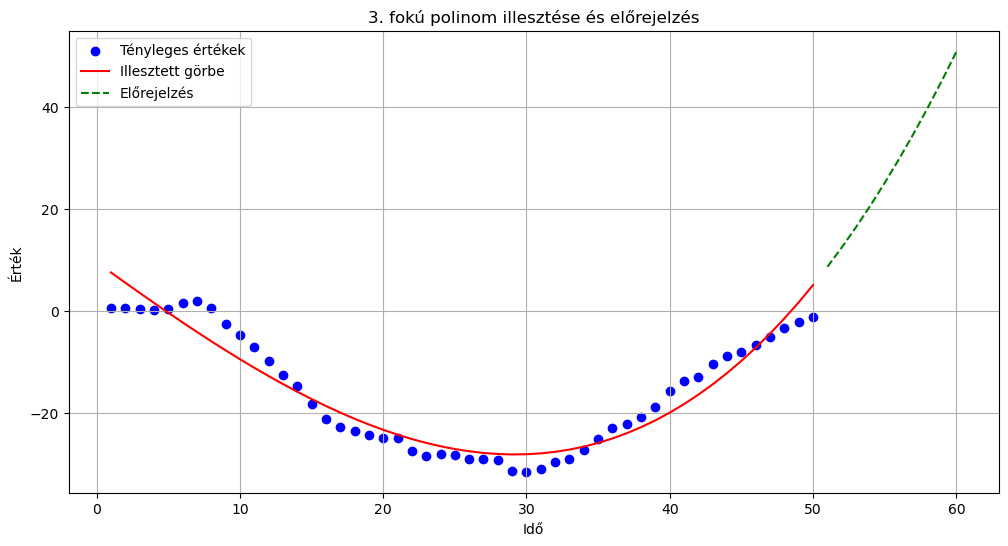

In [17]:
# Modellek összehasonlítása
max_degree = 10
selected_degree = 3  # a kiválasztott fokszám
results = []

# Különböző fokszámú modellek összehasonlítása
for degree in range(0, max_degree):
   X = np.vander(df['Idő'], degree + 1)
   model = sm.OLS(df['Érték'], X).fit()
   r2 = r2_score(df['Érték'], model.fittedvalues)
   
   results.append({
       'Fokszám': degree,
       'R²': r2,
       'AIC': model.aic,
       'BIC': model.bic
   })

# Eredmények kiíratása
results_df = pd.DataFrame(results)
print("\nModellek összehasonlítása:")
print(results_df)

# Kiválasztott fokszámú polinom illesztése
X = np.vander(df['Idő'], selected_degree + 1)
model = sm.OLS(df['Érték'], X).fit()

# Eredmények kiíratása
print(f"\n{selected_degree}. fokú polinom illesztése:")
print(model.summary().tables[0])
print(model.summary().tables[1])

# Reziduálisok vizsgálata
residuals = model.resid

# 1. Várható érték vizsgálata
resid_mean = np.mean(residuals)
resid_std = np.std(residuals, ddof=selected_degree+1)
t_stat = resid_mean / (resid_std/np.sqrt(len(residuals)))
p_value_mean = 2 * stats.t.cdf(-abs(t_stat), len(residuals)-1)

# 2. Normalitás vizsgálata (Shapiro-Wilk teszt)
shapiro_stat, shapiro_p = stats.shapiro(residuals)

# 3. Függetlenség vizsgálata (Durbin-Watson teszt)
dw_stat = sm.stats.stattools.durbin_watson(residuals)

# 4. Homoszkedaszticitás vizsgálata (Breusch-Pagan teszt)
bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, model.model.exog)

print("\nHibatagok vizsgálata - eredmények:")
print("-" * 50)
print(f"1. Várható érték vizsgálata:")
print(f"Átlag (várható érték becslése): {resid_mean:.6f}")
print(f"t-statisztika: {t_stat}")
print(f"p-érték: {p_value_mean}")

print(f"\n2. Normalitás vizsgálata (Shapiro-Wilk):")
print(f"Teszt statisztika: {shapiro_stat:.6f}")
print(f"p-érték: {shapiro_p:.6f}")

print(f"\n3. Függetlenség vizsgálata (Durbin-Watson):")
print(f"DW statisztika: {dw_stat:.6f}")

print(f"\n4. Homoszkedaszticitás vizsgálata (Breusch-Pagan):")
print(f"Teszt statisztika: {bp_test[0]:.6f}")
print(f"p-érték: {bp_test[1]:.6f}")

# Előrejelzés a következő 10 időpontra
future_points = np.arange(len(df) + 1, len(df) + 11)
X_future = np.vander(future_points, selected_degree + 1)
predictions = model.predict(X_future)

print("\nElőrejelzések:")
for i, pred in enumerate(predictions):
   print(f"{future_points[i]}. időpont: {pred:.2f}")

# Ábrázolás
plt.figure(figsize=(12, 6))
plt.scatter(df['Idő'], df['Érték'], color='blue', label='Tényleges értékek')
plt.plot(df['Idő'], model.fittedvalues, color='red', label='Illesztett görbe')
plt.plot(future_points, predictions, color='green', linestyle='--', label='Előrejelzés')
plt.xlabel('Idő')
plt.ylabel('Érték')
plt.title(f'{selected_degree}. fokú polinom illesztése és előrejelzés')
plt.legend()
plt.grid(True)
plt.show()

## Értelmezés ε = 0.05 szignifikanciaszint mellett

### Modellválasztás
Az AIC és BIC értékek alapján a 8. fokú polinom adná a legjobb illeszkedést, azonban a 3. fokú polinom mellett döntöttem az előrejelzés robusztussága miatt.

### Várható érték vizsgálata
H₀: E(ε) = 0  
H₁: E(ε) ≠ 0  
t-statisztika értéke: 0.0000  
p-érték: 0.9999  
Döntés: 0.9999 > 0.05, tehát nem vetjük el H₀-t

### Normalitás vizsgálata (Shapiro-Wilk teszt)
H₀: A hibatagok normális eloszlásúak  
H₁: A hibatagok nem normális eloszlásúak  
Teszt statisztika: 0.9711  
p-érték: 0.2557  
Döntés: 0.2557 > 0.05, tehát nem vetjük el H₀-t

### Függetlenség vizsgálata (Durbin-Watson teszt)
H₀: A hibatagok függetlenek  
H₁: A hibatagok autokorreláltak  
DW statisztika: 0.1610  
Döntés: A DW statisztika 0-hoz közeli értéke erős pozitív autokorrelációt jelez

### Homoszkedaszticitás vizsgálata (Breusch-Pagan teszt)
H₀: A hibatagok homoszkedasztikusak  
H₁: A hibatagok heteroszkedasztikusak  
Teszt statisztika: 16.2548  
p-érték: 0.0010  
Döntés: 0.0010 < 0.05, tehát elvetjük H₀-t

### Összefoglaló értékelés
A hibatagok diagnosztikai vizsgálata alapján:  
- A várható érték feltétel teljesül (az átlag gyakorlatilag 0).  
- A normalitás feltétele teljesül (a hibatagok normális eloszlásúak).  
- A függetlenség feltétele nem teljesül, erős pozitív autokorreláció van jelen.  
- A homoszkedaszticitás feltétele nem teljesül, a hibatagok heteroszkedasztikusak.  

# Exponenciális simítás alkalmazása

## Kód és eredmények


Illeszkedési mutatók:
MAE = 1.3446
MSE = 2.7510
RMSE = 1.6586
Smoothing level (alpha) = 1.0000

Hibatagok vizsgálata - eredmények:
--------------------------------------------------
1. Várható érték vizsgálata:
Átlag: -0.035400
t-statisztika: -0.149436
p-érték: 0.881823

2. Normalitás vizsgálata (Shapiro-Wilk):
Teszt statisztika: 0.961779
p-érték: 0.105540

3. Függetlenség vizsgálata (Durbin-Watson):
DW statisztika: 0.376660

4. Homoszkedaszticitás vizsgálata (Breusch-Pagan teszt):
Teszt statisztika: 0.487821
p-érték: 0.484901

Előrejelzések:
51. időpont: -1.25
52. időpont: -1.25
53. időpont: -1.25
54. időpont: -1.25
55. időpont: -1.25


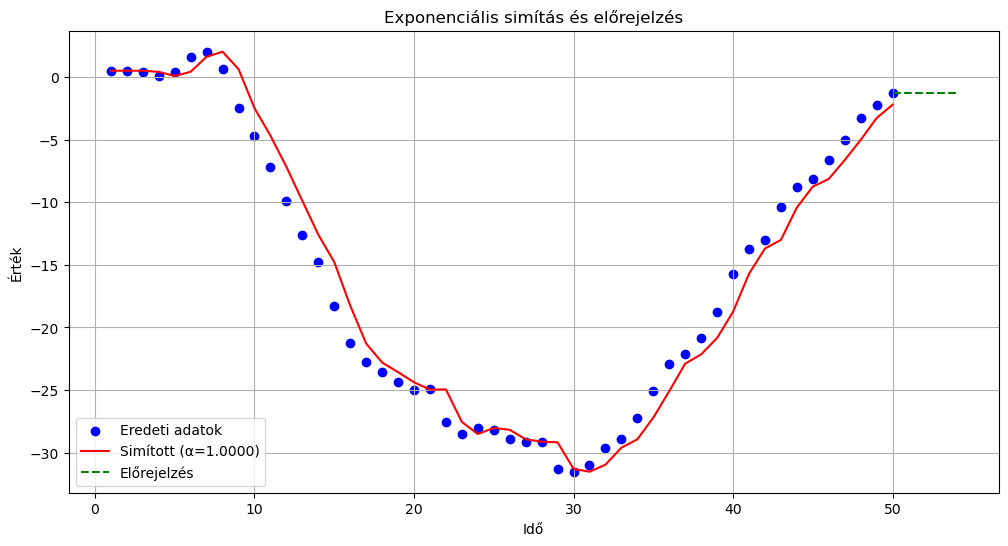

In [20]:
# Exponenciális simítás (optimális alpha meghatározása)
model = SimpleExpSmoothing(df['Érték']).fit()
alpha = model.model.params['smoothing_level']

# Illesztett értékek és előrejelzések
fitted_values = model.fittedvalues
forecast = model.forecast(5)

# Illeszkedés vizsgálata
mae = mean_absolute_error(df['Érték'], fitted_values)
mse = mean_squared_error(df['Érték'], fitted_values)
rmse = np.sqrt(mse)

# Reziduálisok vizsgálata
residuals = model.resid

# 1. Várható érték vizsgálata
resid_mean = np.mean(residuals)
resid_std = np.std(residuals, ddof=1)
t_stat = resid_mean / (resid_std / np.sqrt(len(residuals)))
p_value_mean = 2 * stats.t.cdf(-abs(t_stat), len(residuals) - 1)

# 2. Normalitás vizsgálata (Shapiro-Wilk teszt)
shapiro_stat, shapiro_p = stats.shapiro(residuals)

# 3. Függetlenség vizsgálata (Durbin-Watson teszt)
dw_stat = sm.stats.stattools.durbin_watson(residuals)

# 4. Homoszkedaszticitás vizsgálata (Breusch-Pagan teszt)
exog = sm.add_constant(fitted_values)
bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, exog)

# Eredmények kiírása
print("\nIlleszkedési mutatók:")
print(f"MAE = {mae:.4f}")
print(f"MSE = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"Smoothing level (alpha) = {alpha:.4f}")

print("\nHibatagok vizsgálata - eredmények:")
print("-" * 50)
print("1. Várható érték vizsgálata:")
print(f"Átlag: {resid_mean:.6f}")
print(f"t-statisztika: {t_stat:.6f}")
print(f"p-érték: {p_value_mean:.6f}")

print("\n2. Normalitás vizsgálata (Shapiro-Wilk):")
print(f"Teszt statisztika: {shapiro_stat:.6f}")
print(f"p-érték: {shapiro_p:.6f}")

print("\n3. Függetlenség vizsgálata (Durbin-Watson):")
print(f"DW statisztika: {dw_stat:.6f}")

print("\n4. Homoszkedaszticitás vizsgálata (Breusch-Pagan teszt):")
print(f"Teszt statisztika: {bp_test[0]:.6f}")
print(f"p-érték: {bp_test[1]:.6f}")

print("\nElőrejelzések:")
for i, pred in enumerate(forecast, 1):
    print(f"{len(df) + i}. időpont: {pred:.2f}")

# Ábrázolás
plt.figure(figsize=(12, 6))
plt.scatter(df['Idő'], df['Érték'], color='blue', label='Eredeti adatok')
plt.plot(df['Idő'], fitted_values, 'r-', label=f'Simított (α={alpha:.4f})')

future_points = np.arange(len(df), len(df) + len(forecast))
plt.plot(future_points, forecast, 'g--', label='Előrejelzés')

plt.title('Exponenciális simítás és előrejelzés')
plt.xlabel('Idő')
plt.ylabel('Érték')
plt.legend()
plt.grid(True)
plt.show()


## Exponenciális simítás eredményei

### Modell specifikációk
A modellben a SimpleExpSmoothing függvény által meghatározott α = 1.0000 simítási paramétert használtuk.

### Illeszkedési mutatók
MAE (Mean Absolute Error): 1.3446  
Az átlagos abszolút hiba azt mutatja, hogy az előrejelzéseink átlagosan 1.3446 egységgel térnek el a tényleges értékektől.

MSE (Mean Squared Error): 2.7510  
Az átlagos négyzetes hiba az előrejelzési hibák négyzetének átlaga, jelen esetben 2.7510. Ez a mutató érzékeny a nagyobb eltérésekre, mivel a hibákat négyzetre emeli.

RMSE (Root Mean Squared Error): 1.6586  
A négyzetes átlaggyök hiba az MSE négyzetgyöke, ami az előrejelzési hibák átlagos nagyságát adja meg az eredeti mértékegységben.

Simítási paraméter (alpha): 1.0000  
Az alpha értéke 1.0, ami azt jelenti, hogy a modell teljes mértékben az utolsó megfigyelésre támaszkodik az előrejelzés során. Ebben az esetben a modell nem simítja az adatokat, hanem minden előrejelzés az utolsó ismert érték lesz.

## Hibatagok tulajdonságainak vizsgálata ε = 0.05 szignifikanciaszint mellett

### Várható érték vizsgálata  
H₀: E(ε) = 0  
H₁: E(ε) ≠ 0  
t-statisztika értéke: -0.1494  
p-érték: 0.8818  
Döntés: 0.8818 > 0.05, tehát nem vetjük el H₀-t  

### Normalitás vizsgálata (Shapiro-Wilk teszt)  
H₀: A hibatagok normális eloszlásúak  
H₁: A hibatagok nem normális eloszlásúak  
Teszt statisztika: 0.9618  
p-érték: 0.1055  
Döntés: 0.1055 > 0.05, tehát nem vetjük el H₀-t  

### Függetlenség vizsgálata (Durbin-Watson teszt)  
H₀: A hibatagok függetlenek  
H₁: A hibatagok autokorreláltak  
DW statisztika: 0.3767  
Döntés: A DW statisztika 0-hoz közeli értéke erős pozitív autokorrelációt jelez, ami azt sugallja, hogy a modell nem kezeli megfelelően az időbeli függőségeket, és az előrejelzési hibák egymással korreláltak.

### Homoszkedaszticitás vizsgálata (Breusch-Pagan teszt)  
H₀: A hibatagok homoszkedasztikusak  
H₁: A hibatagok heteroszkedasztikusak  
Teszt statisztika: 0.4878  
p-érték: 0.4849  
Döntés: 0.4849 > 0.05, tehát nem vetjük el H₀-t  

## Összefoglaló értékelés  
A hibatagok diagnosztikai vizsgálata alapján:  
- A várható érték feltétel teljesül (az átlag gyakorlatilag 0)  
- A normalitás feltétele teljesül (a hibatagok normális eloszlásúak)  
- A függetlenség feltétele nem teljesül, erős pozitív autokorreláció van jelen  
- A homoszkedaszticitás feltétele teljesül (a szórás állandó)

# Box-Jenkins modell

## Kód és eredmények


ADF Teszt eredménye:
ADF Statisztika: -2.5644
p-érték: 0.1006


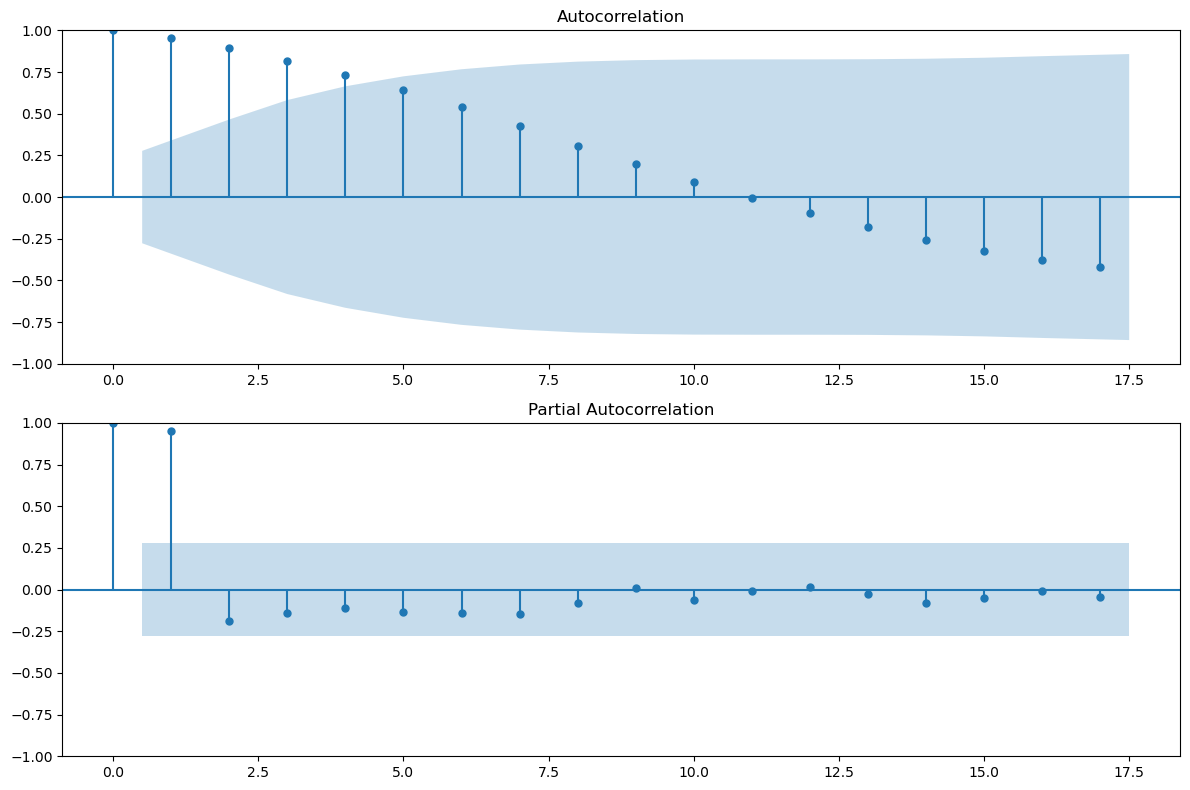


Modell eredmények:
                               SARIMAX Results                                
Dep. Variable:                  Érték   No. Observations:                   50
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -68.798
Date:                Sat, 30 Nov 2024   AIC                            143.597
Time:                        20:32:09   BIC                            149.272
Sample:                             0   HQIC                           145.750
                                 - 50                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8688      0.090      9.658      0.000       0.692       1.045
ma.L1         -0.2181      0.159     -1.372      0.170      -0.530       0.094
sigma2         0.9504      0.193

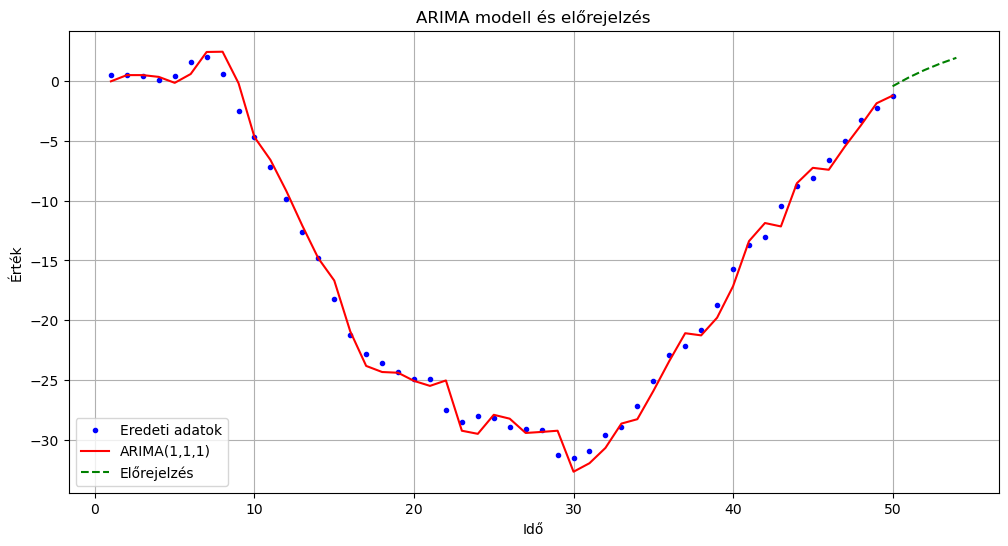

In [13]:
# Idősor stacionaritásának vizsgálata (ADF teszt)
adf_result = adfuller(df['Érték'])
print('\nADF Teszt eredménye:')
print(f'ADF Statisztika: {adf_result[0]:.4f}')
print(f'p-érték: {adf_result[1]:.4f}')

# ACF és PACF ábrák a paraméterek meghatározásához
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Érték'], ax=ax1)
plot_pacf(df['Érték'], ax=ax2)
plt.tight_layout()
plt.show()

# ARIMA modell illesztése
p, d, q = 1, 1, 1 
model = ARIMA(df['Érték'], order=(p, d, q))
results = model.fit()

# Illesztett értékek és előrejelzések
fitted_values = results.fittedvalues
forecast = results.forecast(steps=5)

# Reziduálisok vizsgálata
residuals = results.resid

# 1. Várható érték vizsgálata
resid_mean = np.mean(residuals)
resid_std = np.std(residuals, ddof=1)
t_stat = resid_mean / (resid_std/np.sqrt(len(residuals)))
p_value_mean = 2 * stats.t.cdf(-abs(t_stat), len(residuals)-1)

# 2. Normalitás vizsgálata
shapiro_stat, shapiro_p = stats.shapiro(residuals)

# 3. Függetlenség vizsgálata
dw_stat = sm.stats.stattools.durbin_watson(residuals)

# 4. Homoszkedaszticitás vizsgálata
exog = sm.add_constant(fitted_values)
bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, exog)

print('\nModell eredmények:')
print(results.summary().tables[0])
print(results.summary().tables[1])

print('\nHibatagok vizsgálata:')
print(f'Várható érték teszt p-érték: {p_value_mean:.4f}')
print(f'Shapiro-Wilk teszt p-érték: {shapiro_p:.4f}')
print(f'Durbin-Watson statisztika: {dw_stat:.4f}')
print(f'Breusch-Pagan teszt p-érték: {bp_test[1]:.4f}')

print('\nElőrejelzések:')
for i, pred in enumerate(forecast, 1):
    print(f'{len(df) + i}. időpont: {pred:.2f}')

# Ábrázolás
plt.figure(figsize=(12, 6))
plt.plot(df['Idő'], df['Érték'], 'b.', label='Eredeti adatok')
plt.plot(df['Idő'], fitted_values, 'r-', label=f'ARIMA({p},{d},{q})')
future_points = np.arange(len(df), len(df) + 5)
plt.plot(future_points, forecast, 'g--', label='Előrejelzés')
plt.title('ARIMA modell és előrejelzés')
plt.xlabel('Idő')
plt.ylabel('Érték')
plt.legend()
plt.grid(True)
plt.show()

## Értelmezés ε = 0.05 szignifikanciaszint mellett

### ADF teszt eredménye
H₀: Az idősor nem stacionárius  
H₁: Az idősor stacionárius  
ADF Statisztika: -2.5644  
p-érték: 0.1006  
Döntés: 0.1006 > 0.05, tehát nem vetjük el H₀-t, az idősor nem stacionárius  

### Modell paraméterek
ARIMA(1,1,1) modellt illesztettünk, ahol:  
- p = 1 (autoregresszív tag): 0.8688  
- d = 1 (differenciálás rendje)  
- q = 1 (mozgóátlag tag): -0.2181  

### Paraméterek szignifikanciája
- AR(1) tag: p-érték = 0.000 < 0.05, szignifikáns  
- MA(1) tag: p-érték = 0.170 > 0.05, nem szignifikáns  

### Modell illeszkedési mutatók
AIC: 143.597  
BIC: 149.272  
Log Likelihood: -68.798 

## Hibatagok tulajdonságainak vizsgálata
### Várható érték vizsgálata  
p-érték: 0.8523 > 0.05, tehát nem vetjük el H₀-t  

### Normalitás vizsgálata (Shapiro-Wilk teszt)  
p-érték: 0.0627 > 0.05, tehát nem vetjük el H₀-t  

### Függetlenség vizsgálata (Durbin-Watson teszt)  
DW statisztika: 1.8668  
Döntés: A DW statisztika közel van 2-höz, a függetlenség feltétele teljesül  

### Homoszkedaszticitás vizsgálata (Breusch-Pagan teszt)  
p-érték: 0.5577 > 0.05, tehát nem vetjük el H₀-t  

## Összefoglaló értékelés  
- A modell diagnosztikája megfelelő:
  - A várható érték feltétel teljesül
  - A hibatagok normális eloszlásúak
  - A függetlenség feltétele teljesül
  - A homoszkedaszticitás feltétele teljesül
- Az AR(1) tag szignifikáns, míg az MA(1) tag nem
- Az előrejelzések növekvő trendet mutatnak